In [1]:
import pandas as pd
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [2]:
sys.path.append('/home/khanalp/code/PhD/utils')
from utils import read_csv_file_with_station_name

In [3]:

def temperature_from_lw_out(lw_out: np.ndarray, emissivity: float) -> np.ndarray:
    """
    Calculate temperature (in Kelvin) from longwave radiation using the Stefan-Boltzmann law.

    Parameters:
        lw_out (np.ndarray or float): Outgoing longwave radiation in W/m²
        emissivity (float): Emissivity of the surface (0 < emissivity ≤ 1)

    Returns:
        np.ndarray: Temperature in Kelvin (same shape as input)
    """
    sigma = 5.670374419e-8  # W/m²/K⁴
    
    # Check emissivity is scalar and in valid range
    if not (0 < emissivity <= 1):
        raise ValueError("Emissivity must be in the range (0, 1].")
    
    lw_out = np.asarray(lw_out)
    
    if np.any(lw_out < 0):
        raise ValueError("LW_OUT values must be non-negative.")
    
    return (lw_out / (emissivity * sigma)) ** 0.25


In [4]:
data_path = "/home/khanalp/testcase/DE-Tha"

In [6]:
station = "IT-MBo"
path_insitu_flux = "/home/khanalp/data/processed/insituflux_with_qc"
path_insitu_forcing = "/home/khanalp/data/processed/input_pystemmus/v1"
ICOS_location = "/home/khanalp/data/ICOS2020"
station_details = "/home/khanalp/code/PhD/preprocessICOSdata/csvs/02_station_with_elevation_heightcanopy.csv"
metrics_path = "/home/khanalp/code/PhD/analysis/csvs/03_metrics_quality_controlled.csv"
v2 = "vMay13" # Model version to check with output


In [7]:
# Find insitu flux file
file_insitu_flux = [os.path.join(path_insitu_flux, f) for f in os.listdir(path_insitu_flux) if station in f]
ds_insitu_flux = xr.open_dataset(file_insitu_flux[0])

In [8]:
# Read insitu full file
df_insitu_ICOS = read_csv_file_with_station_name(ICOS_location, station)

In [9]:
 # Assign datetime coordinates to the 'index' dimension based on the 'TIMESTAMP_START' column
df_insitu_ICOS['time'] = pd.to_datetime(df_insitu_ICOS['TIMESTAMP_START'], format='%Y%m%d%H%M')
df_insitu_ICOS.set_index('time', inplace=True)

In [10]:
start_date = pd.to_datetime("2004-07-01")
end_date = pd.to_datetime("2004-07-07")

In [11]:
# Replace -9999 with NaN in the DataFrame
df_insitu_ICOS.replace(-9999, np.nan, inplace=True)

In [12]:
df_insitu_selected = df_insitu_ICOS.loc[start_date:end_date]

<Axes: xlabel='time'>

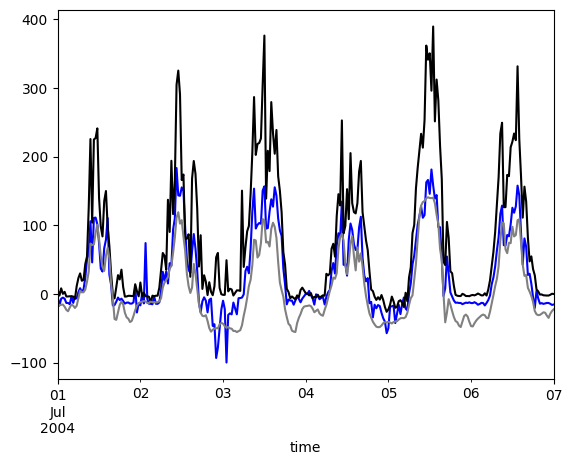

In [13]:
df_insitu_selected['H_F_MDS'].plot(color = 'blue')
df_insitu_selected['LE_F_MDS'].plot(color = 'black')
df_insitu_selected['G_F_MDS'].plot(color = 'grey')

<Axes: xlabel='time'>

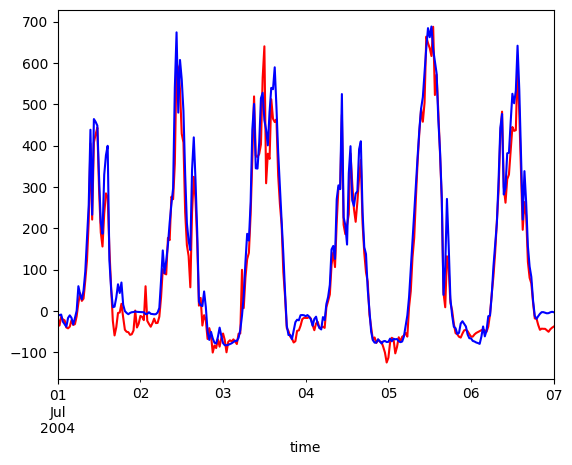

In [17]:
(df_insitu_selected['H_F_MDS']+df_insitu_selected['LE_F_MDS']+df_insitu_selected['G_F_MDS']).plot(color = 'red')
df_insitu_selected['NETRAD'].plot(color = 'blue')

In [36]:
# Find insitu forcing file used to run the model.
file_insitu_forcing = [os.path.join(path_insitu_forcing, f) for f in os.listdir(path_insitu_forcing) if station in f]
ds_insitu_forcing = xr.open_dataset(file_insitu_forcing[0])

In [37]:
# THis is the time period of the model run
start_time = pd.to_datetime("2005-07-12 00:00:00")
end_time = pd.to_datetime("2005-07-19 23:30:00")

In [38]:
# I want to select the time period of the model run
ds_insitu_flux_selected = ds_insitu_flux.sel(time=slice(start_time, end_time))
ds_insitu_forcing_selected = ds_insitu_forcing.sel(time=slice(start_time, end_time))
df_insitu_ICOS_selected = df_insitu_ICOS.loc[start_time:end_time]

In [30]:
# Replace -9999 with NaN in the DataFrame
df_insitu_ICOS_selected.replace(-9999, np.nan, inplace=True)

NameError: name 'df_insitu_ICOS_selected' is not defined

In [40]:
# COmpute LST In degree C from LW_OUT
df_insitu_ICOS_selected['LST'] = temperature_from_lw_out(
    df_insitu_ICOS_selected['LW_OUT'].values,
    emissivity=0.98
) - 273.15

/home/khanalp/tmp/ipykernel_219485/2961383084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_insitu_ICOS_selected['LST'] = temperature_from_lw_out(


In [41]:
# FOr corresponding version, model output
df_fluxes_parallel = pd.read_csv(os.path.join(data_path, v2, "fluxes.csv"))
df_resistance_parallel = pd.read_csv(os.path.join(data_path, v2, "output_resistances.csv"))

In [42]:
# Remove first row in case of fluxes
df_fluxes_parallel = df_fluxes_parallel.iloc[1:,]

In [43]:
#Make everything numeric
df_fluxes_parallel = df_fluxes_parallel.apply(pd.to_numeric, errors='coerce')
df_resistance_parallel = df_resistance_parallel.apply(pd.to_numeric, errors='coerce')


In [44]:
# Add time column to the DataFrames and make it index 
df_fluxes_parallel['time'] = pd.to_datetime(ds_insitu_flux_selected['time'].values.flatten())
df_resistance_parallel['time'] = pd.to_datetime(ds_insitu_flux_selected['time'].values.flatten())
df_fluxes_parallel.set_index('time', inplace=True)
df_resistance_parallel.set_index('time', inplace=True)

In [45]:
# COmpute insitu air temperature in degree C
ds_insitu_forcing_selected['Tair_degC'] = ds_insitu_forcing_selected['Tair'] - 273.15

In [46]:
# TO further look into some days.
start_time_poi = pd.to_datetime("2005-07-12 00:00:00")
end_time_poi = pd.to_datetime("2005-07-19 23:30:00")

In [47]:
df_fluxes_parallel_poi = df_fluxes_parallel.loc[start_time_poi:end_time_poi]
ds_insitu_flux_poi = ds_insitu_flux_selected.sel(time=slice(start_time_poi, end_time_poi))

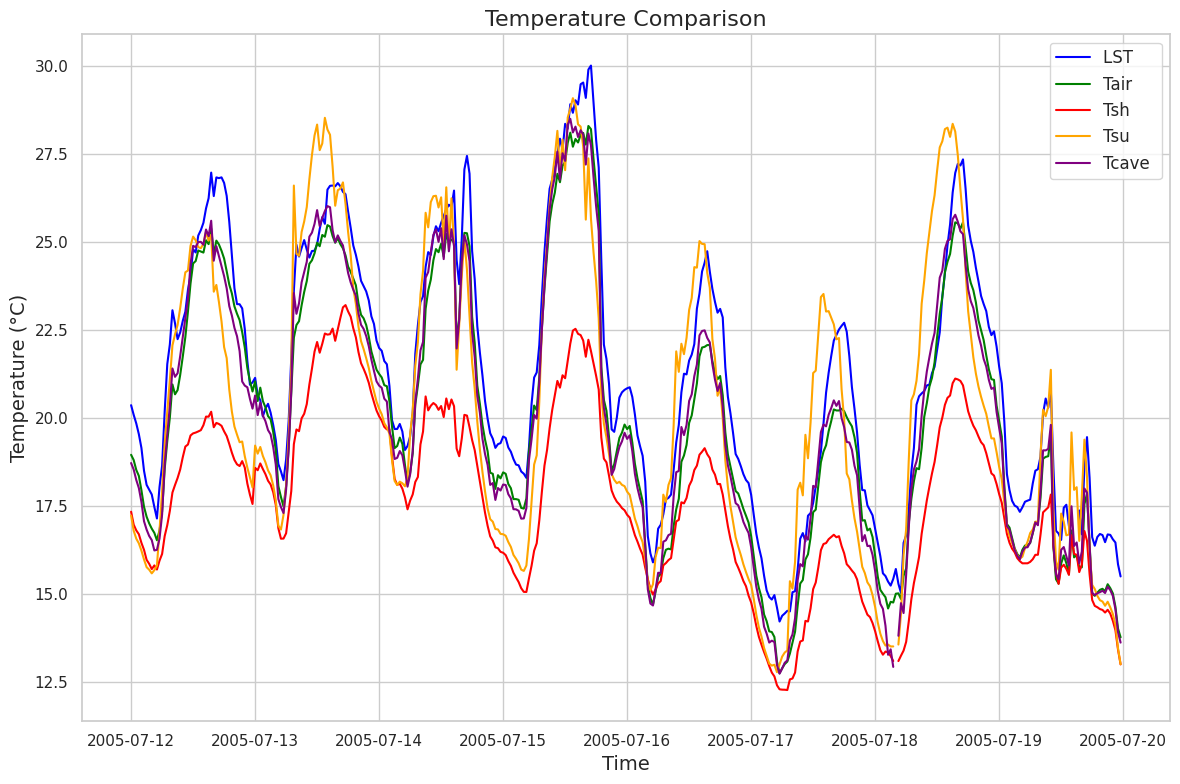

In [48]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot each variable
plt.plot(df_insitu_ICOS_selected.index, df_insitu_ICOS_selected['LST'], label='LST ', color='blue', linewidth=1.5)
plt.plot(ds_insitu_forcing_selected['time'].values.flatten(), ds_insitu_forcing_selected['Tair_degC'].values.flatten(), label='Tair ', color='green', linewidth=1.5)
plt.plot(df_resistance_parallel.index, df_resistance_parallel['Tsh'], label='Tsh ', color='red', linewidth=1.5)
plt.plot(df_resistance_parallel.index, df_resistance_parallel['Tsu'], label='Tsu ', color='orange', linewidth=1.5)
plt.plot(df_resistance_parallel.index, df_resistance_parallel['Tcave'], label='Tcave ', color='purple', linewidth=1.5)

# Add labels, legend, and title
plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.title('Temperature Comparison', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

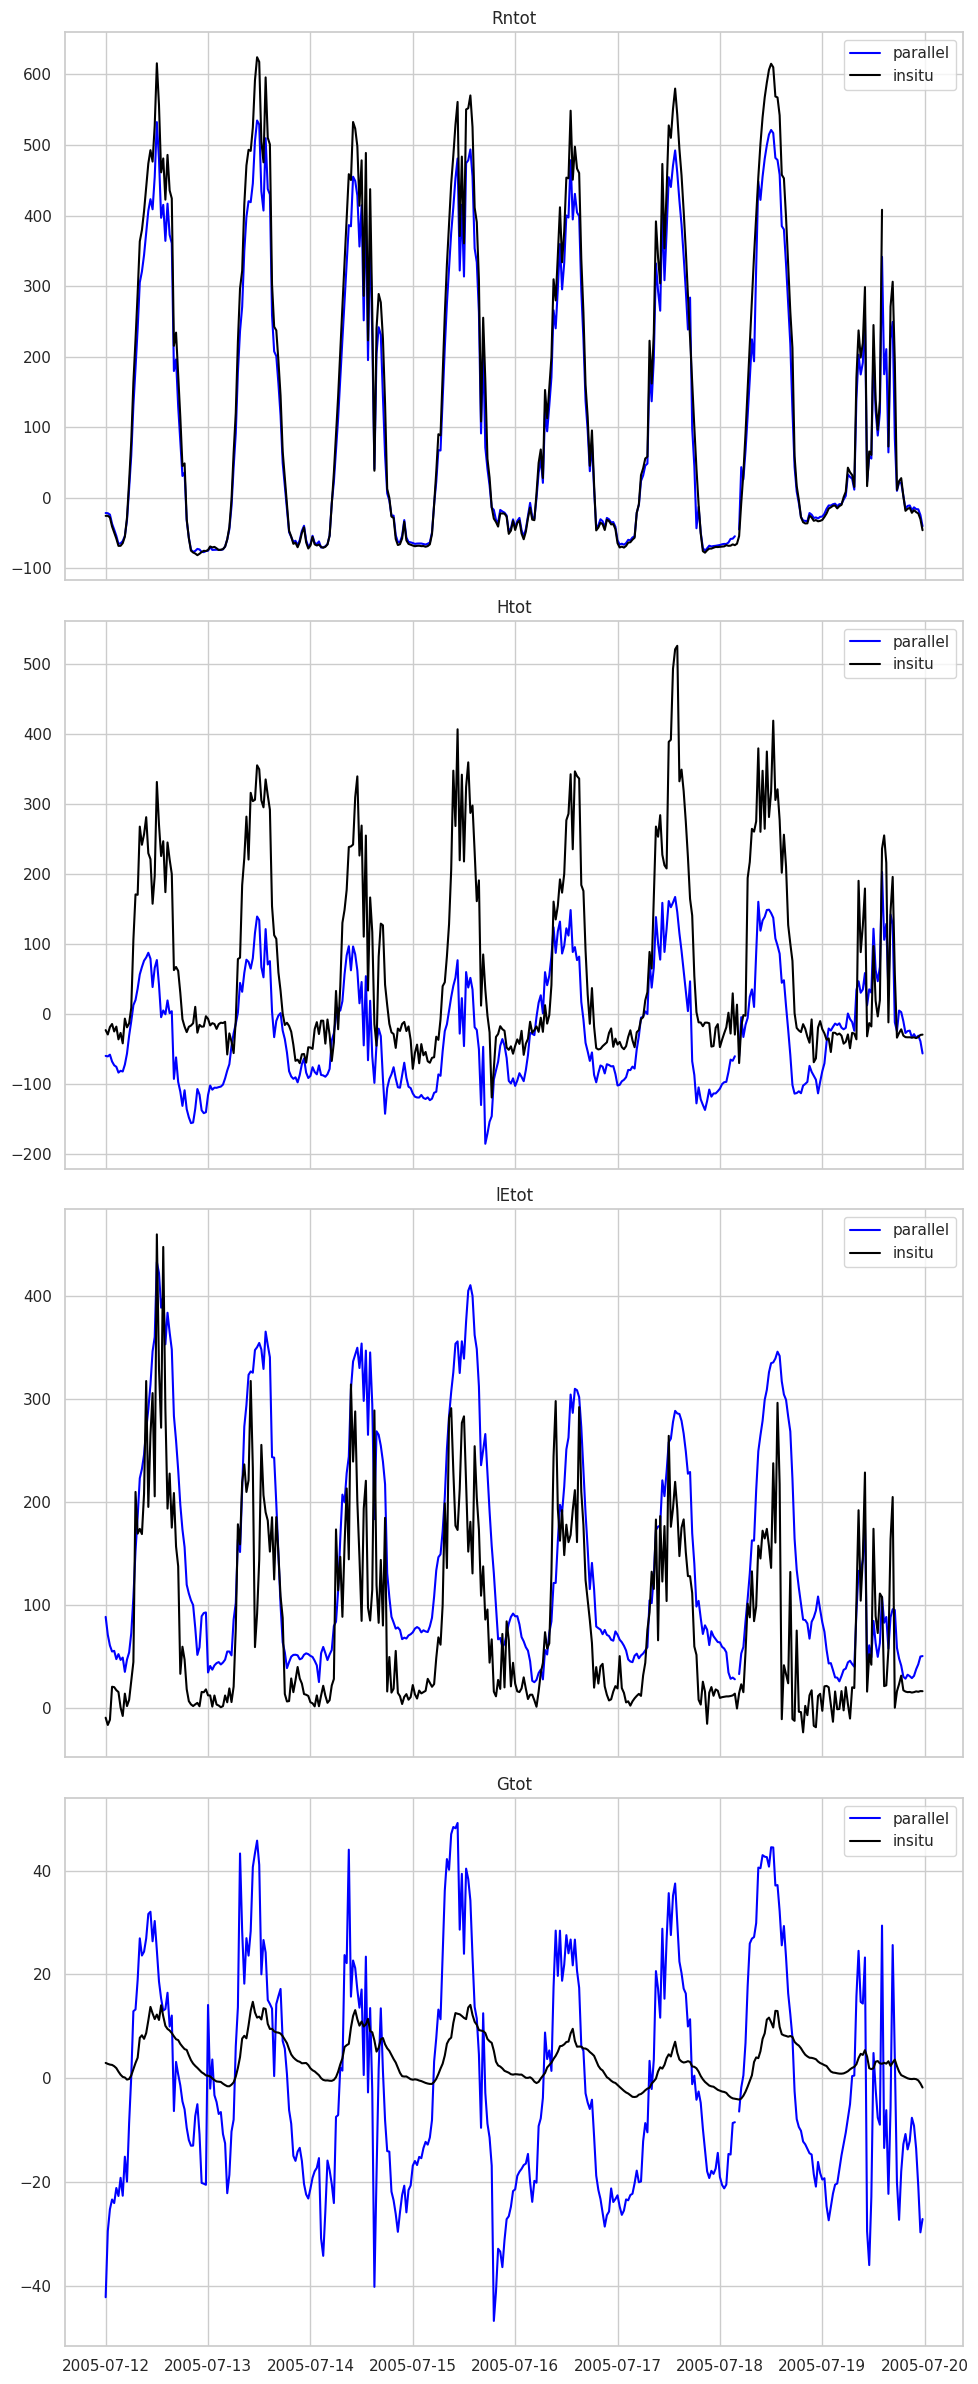

In [49]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(4, 1, figsize=(10, 24), sharex=True)

# Plot 1: Rntot
# axs[0].plot(df_fluxes_base_poi.index, df_fluxes_base_poi.Rntot, label='base', color='red', linewidth=1.5)
axs[0].plot(df_fluxes_parallel_poi.index, df_fluxes_parallel_poi.Rntot, label='parallel', color='blue', linewidth=1.5)
axs[0].plot(ds_insitu_flux_poi.time.values.flatten(), ds_insitu_flux_poi.Rnet.values.flatten(), label='insitu', color='black', linewidth=1.5)
axs[0].set_title('Rntot')
axs[0].legend()

# Plot 2: Htot
axs[1].plot(df_fluxes_parallel_poi.index, df_fluxes_parallel_poi.Htot, label='parallel', color='blue', linewidth=1.5)
axs[1].plot(ds_insitu_flux_poi.time.values.flatten(), ds_insitu_flux_poi.Qh_cor.values.flatten(), label='insitu', color='black', linewidth=1.5)
axs[1].set_title('Htot')
axs[1].legend()

# Plot 3: lEtot
axs[2].plot(df_fluxes_parallel_poi.index, df_fluxes_parallel_poi.lEtot, label='parallel', color='blue', linewidth=1.5)
axs[2].plot(ds_insitu_flux_poi.time.values.flatten(), ds_insitu_flux_poi.Qle_cor.values.flatten(), label='insitu', color='black', linewidth=1.5)
axs[2].set_title('lEtot')
axs[2].legend()

# Plot 4: Gtot
# axs[3].plot(df_fluxes_base_poi.index, df_fluxes_base_poi.Gtot, label='base', color='red', linewidth=1.5)
axs[3].plot(df_fluxes_parallel_poi.index, df_fluxes_parallel_poi.Gtot, label='parallel', color='blue', linewidth=1.5)
# axs[3].plot(df_fluxes_alternate_poi.index, df_fluxes_alternate_poi.Gtot, label='alternate', color='green', linewidth=1.5)
axs[3].plot(ds_insitu_flux_poi.time.values.flatten(), ds_insitu_flux_poi.Qg.values.flatten(), label='insitu', color='black', linewidth=1.5)
axs[3].set_title('Gtot')
axs[3].legend()

# Adjust layout
plt.tight_layout()
plt.show()


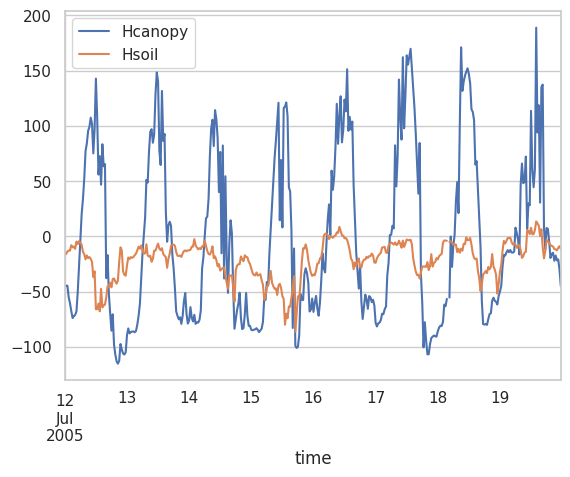

In [27]:
df_fluxes_parallel['Hctot'].plot(label = "Hcanopy")
df_fluxes_parallel['Hstot'].plot(label = "Hsoil")
plt.legend()

In [8]:
df_station_details = pd.read_csv(station_details)

In [9]:
df_metrics = pd.read_csv(metrics_path)

In [16]:
df_metrics['landuse'] = df_metrics['station_name'].map(df_station_details.set_index('station_name')['IGBP_short_name'])

In [26]:
df_metrics_filtered = df_metrics[(df_metrics['landuse'] == "GRA") & (df_metrics['variable'] == "Qh")]
df_metrics_sorted = df_metrics_filtered.sort_values(by="R_square", ascending=False)
df_metrics_sorted

,station_name,variable,count,slope,intercept,R_square,rmse,pearson_r,kge,IGBP_short_name,landuse
231,DE-Gri,Qh,181915.0,0.928925,4.933750,0.648271,34.938459,0.846315,0.608900,GRA,GRA
241,IT-MBo,Qh,176750.0,0.807960,10.397290,0.610352,46.033784,0.810255,0.389021,GRA,GRA
236,DE-RuR,Qh,101836.0,1.383145,6.006842,0.437433,47.770385,0.911122,-0.102605,GRA,GRA
226,CH-Fru,Qh,88267.0,1.197766,-1.235581,0.288361,60.207957,0.825412,0.497566,GRA,GRA
246,IT-Tor,Qh,107169.0,1.101248,-6.268290,0.258145,74.266738,0.790080,0.537881,GRA,GRA
221,CH-Cha,Qh,134003.0,1.322852,12.922697,0.005352,57.266689,0.834104,-0.076498,GRA,GRA
216,CH-Aws,Qh,18428.0,1.497526,-11.983812,-0.104950,54.066799,0.851516,0.176908,GRA,GRA
211,BE-Dor,Qh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,GRA
